In [1]:
#import every function and library needed

import cv2
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.io import imread
from skimage.transform import rotate, resize

In [34]:
#This function alignes two images based on ORB detected simularities. 
#Code from https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/ and slightly modified

MAX_FEATURES = 1000
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

    # Convert images to grayscale
    if im1.ndim > 2:
        im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    else:
        im1Gray = im1
    if im2.ndim > 2:
        im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    else:
        im2Gray = im2
        
    if im1Gray = none || im2Gray = none:
        print(One of the images was not initalized)
        return "Error"

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    return im1Reg, im2, h

SyntaxError: invalid syntax (1906253900.py, line 19)

uint8
float64
uint8
3


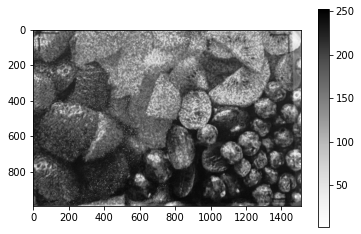

In [35]:
# Open the image files.
imReference = imread('Filters-Round-1/RGB_0.1mm_1a.tif')
film_img = imread('Fruit-Bowl/RGB_0.1mm_1a.jpg')

#crop the middle of film_img?
mask = np.zeros((len(film_img[:,0]), len(film_img[0,:]),3), dtype=int).astype('uint8') + 255
film_img = film_img * mask / 255
film_img = film_img

#process Film shot to right size and var type
imReference = (imReference / 255).astype('uint8')
rot_film_img = rotate(film_img, 90, mode='wrap')
crop_film_img = rot_film_img[1580:2575,590:2100,:]
crop_film_img = (crop_film_img * 255).astype('uint8')

#Process the images to be better orb'd
imReference = (imReference>200).astype('uint8')

crop_film_img = cv2.cvtColor(crop_film_img, cv2.COLOR_BGR2GRAY)

#check datatypes TODO remove when working
print(imReference.dtype)
print(film_img.dtype)
print(crop_film_img.dtype)
print(imReference.ndim)

#prepare to send images to alignment function and last checks
im = crop_film_img
im = im.astype('uint8')
plt.imshow(crop_film_img, cmap="Greys")
plt.colorbar()

In [36]:
#Align photos, using the borrowed ORB matching
print("Aligning images ...")
#Check to make sure we are passing good images of the right type
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, imFilt, h = alignImages(im, imReference)
# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...


error: OpenCV(4.5.5) /io/opencv/modules/core/src/batch_distance.cpp:274: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'batchDistance'


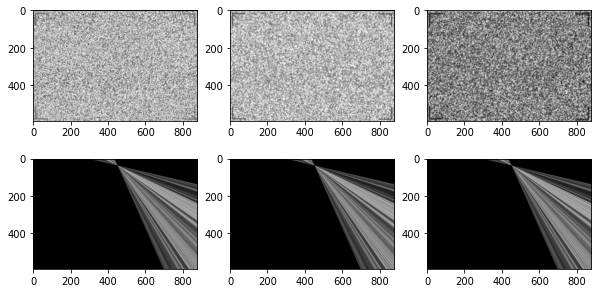

In [110]:
#Break the filter into component RGB colors

filterR = imFilt[:,:,0]
filterG = imFilt[:,:,1]
filterB = imFilt[:,:,2]

film = imReg

fig, axs = plt.subplots(2,3, figsize=(10, 5))
axs[0,0].imshow(filterR, cmap='gray')
axs[0,1].imshow(filterG, cmap='gray')
axs[0,2].imshow(filterB, cmap='gray')
axs[1,0].imshow(film, cmap='gray')
axs[1,1].imshow(film, cmap='gray')
axs[1,2].imshow(film, cmap='gray')
plt.show()

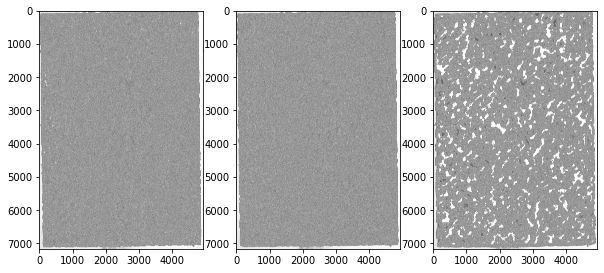

In [32]:
#Multiply each filter color by the black and white film photo

fig, axs = plt.subplots(1,3, figsize=(10, 5))
R = filterR * film
G = filterG * film
B = filterB * film
axs[0].imshow(R, cmap='Greys')
axs[1].imshow(G, cmap='Greys')
axs[2].imshow(B, cmap='Greys')
plt.show()

In [33]:
#Add the color spectra together to get reconstructed color image

R_new = np.expand_dims(R, 2)
G_new = np.expand_dims(G, 2)
B_new = np.expand_dims(B, 2)
temp = np.append(R_new, G_new, axis=2)
reconst_img = np.append(temp, B_new, axis=2)

plt.imshow(reconst_img/255)

[[2.55 2.55 2.55 ... 2.55 2.55 2.55]
 [2.55 2.55 2.55 ... 2.55 2.55 2.55]
 [2.55 2.55 2.55 ... 2.55 2.55 2.55]
 ...
 [0.   0.   0.   ... 2.55 2.55 2.55]
 [0.   0.   0.   ... 2.55 2.55 2.55]
 [0.   0.   0.   ... 2.55 2.55 2.55]]
Saving aligned image :  aligned.jpg
Estimated homography : 
 [[ 9.99160201e-01  2.17807879e-02 -1.51452209e+02]
 [-2.08879106e-02  1.00150772e+00 -1.59567046e+01]
 [-1.53673809e-07  2.24598572e-07  1.00000000e+00]]


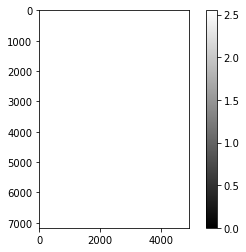

In [25]:
#Last checks as the programer/artist pleases

plt.imshow(imColor_Green, cmap="gray")
plt.colorbar()
print(imColor_Green)

# Write colorized image to disk.
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename);
cv2.imwrite(outFilename, imColor_Green)